
### 1. Data reading


In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn.functional as F
from torchsummary import summary
from utils import show_examples, UnNormalize, train, plot_history, plot_confusion_matrix, compute_confusion_matrix

In [2]:
transform = transforms.Compose([
        transforms.Resize((32,32)),
         transforms.RandomHorizontalFlip(),
         transforms.ToTensor(),
         transforms.Normalize(
         (0.1307,), (0.3081,)
         )
]) 

In [3]:
Batch_Size = 128

In [4]:
trainset = datasets.MNIST(root='./data', train=True,download=True, transform=transform)
testset = datasets.MNIST(root='./data',train=False,download=True,transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=Batch_Size,shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=Batch_Size,shuffle=True, num_workers=2)
classes = ('0', '1', '2', '3', '4','5', '6', '7', '8', '9')


### 2. View data (format, size, shape)


In [5]:
classes = trainset.classes
classes

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

In [6]:
trainset.class_to_idx

{'0 - zero': 0,
 '1 - one': 1,
 '2 - two': 2,
 '3 - three': 3,
 '4 - four': 4,
 '5 - five': 5,
 '6 - six': 6,
 '7 - seven': 7,
 '8 - eight': 8,
 '9 - nine': 9}

In [7]:
print(type(trainset.data))
print(type(trainset))

<class 'torch.Tensor'>
<class 'torchvision.datasets.mnist.MNIST'>



### Summarize:

### 3. View pictures


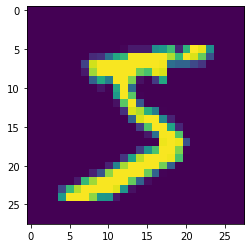

In [8]:
import numpy as np
import matplotlib.pyplot as plt
plt.imshow(trainset.data[0])
im,label = iter(trainloader).next()

In [9]:
def imshow(img):
    img = img / 2 + 0.5
    img = np.transpose(img.numpy(),(1,2,0))
    plt.imshow(img)

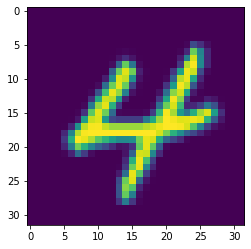

In [10]:
imshow(im[0])

In [11]:
im[0].shape

torch.Size([1, 32, 32])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


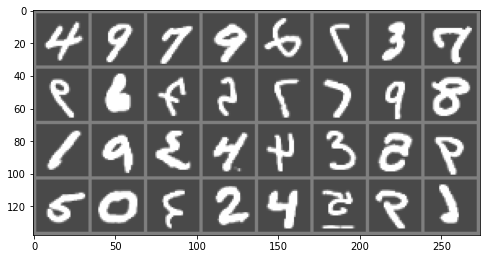

In [12]:
plt.figure(figsize=(8,12))
imshow(torchvision.utils.make_grid(im[:32]))


### 4. Definition Network (VGG)


In [13]:
device = 'cuda' if torch.cuda.is_available() else 'cpu' # 判断是否用GPU
device

'cuda'

In [14]:
cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

In [15]:
class VGG(nn.Module):
    
    def __init__(self, vgg_name):
        super(VGG, self).__init__()
        self.features = self._make_layers(cfg[vgg_name])
        self.classifier = nn.Sequential(
            nn.Linear(512,512),
            nn.ReLU(True),
            nn.Dropout(0.2),
            nn.Linear(512,512),
            nn.ReLU(True),
            nn.Dropout(0.2),
            nn.Linear(512,10),
        )
# self.classifier = nn.Linear(512,10)

        self._initialize_weight()
        
    def forward(self, x):
        out = self.features(x)
        # entering
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out
    
    # make layers
    def _make_layers(self, cfg):
        layers = []
        in_channels = 1 # RGB initial channel is 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)] # kernel_size is 2 x 2, then step size is 2
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1), # are all convolution kernels of (3.3)
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)] # RelU
                in_channels = x # redefine channels
# layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)
    
    # Initialization parameters
    def _initialize_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                # xavier is used in VGG's paper
                nn.init.xavier_normal_(m.weight.data)
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.weight.data.normal_(0, 0.01)
                m.bias.data.zero_()
net = VGG('VGG16').to(device)

In [16]:
summary(net,(1,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]             640
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,928
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
         MaxPool2d-7           [-1, 64, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]          73,856
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,584
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
        MaxPool2d-14            [-1, 12

In [17]:
print(net)

VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [18]:
x = torch.randn(2,1,32,32).to(device)
y = net(x)
print(y.shape)

torch.Size([2, 10])


In [19]:
net = VGG('VGG16').to(device)
if device == 'cuda':
    net = nn.DataParallel(net)
    # When the calculation graph does not change (the input shape is the same each time, the model does not change), the performance can be improved, otherwise the performance will be reduced
    torch.backends.cudnn.benchmark=True


### 5. Define the loss function and optimizer


In [20]:
import torch.optim as optim
optimizer = optim.SGD(net.parameters(), lr=1e-3, momentum=0.9, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5,verbose=True,patience = 5,min_lr = 0.000001) 
# scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[75, 150], gamma=0.5)

import time
epoch = 20


### 6. Training


In [21]:
import os
if not os.path.exists('./model'):
    os.makedirs('./model')
else:
    print('The file already exists')
save_path = './model/VGG16.pth'

The file already exists


In [22]:

Acc, Loss, Lr = train(net, trainloader, testloader, epoch, optimizer, criterion, scheduler, save_path, verbose = True)

Epoch [  1/ 20]  Train Loss:2.225087  Train Acc:19.20% Test Loss:1.893747  Test Acc:29.81%  Learning Rate:0.001000	Time 00:19
Epoch [  2/ 20]  Train Loss:1.263128  Train Acc:53.22% Test Loss:0.481657  Test Acc:84.89%  Learning Rate:0.001000	Time 00:18
Epoch [  3/ 20]  Train Loss:0.255598  Train Acc:92.89% Test Loss:0.140414  Test Acc:95.89%  Learning Rate:0.001000	Time 00:18
Epoch [  4/ 20]  Train Loss:0.108557  Train Acc:97.00% Test Loss:0.108039  Test Acc:97.03%  Learning Rate:0.001000	Time 00:18
Epoch [  5/ 20]  Train Loss:0.072215  Train Acc:97.95% Test Loss:0.064058  Test Acc:98.04%  Learning Rate:0.001000	Time 00:18
Epoch [  6/ 20]  Train Loss:0.053961  Train Acc:98.51% Test Loss:0.083307  Test Acc:97.38%  Learning Rate:0.001000	Time 00:18
Epoch [  7/ 20]  Train Loss:0.042241  Train Acc:98.80% Test Loss:0.054018  Test Acc:98.41%  Learning Rate:0.001000	Time 00:18
Epoch [  8/ 20]  Train Loss:0.034061  Train Acc:99.07% Test Loss:0.046877  Test Acc:98.48%  Learning Rate:0.001000	Tim

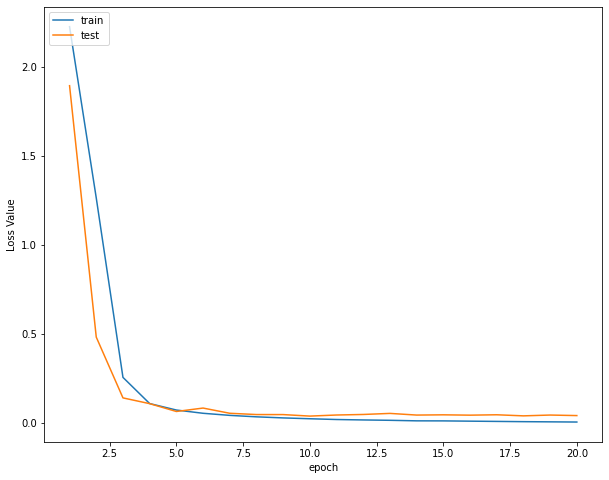

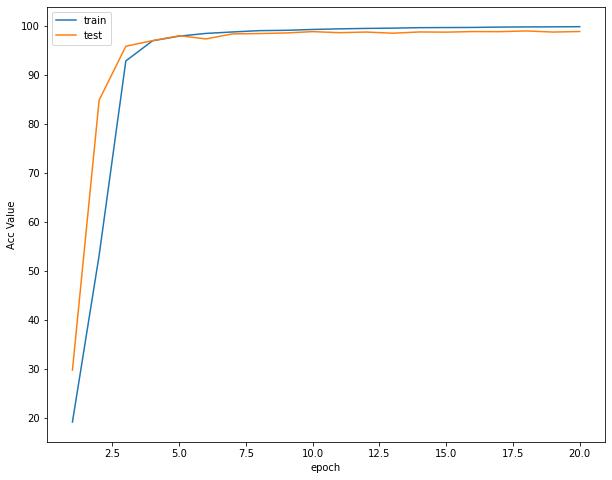

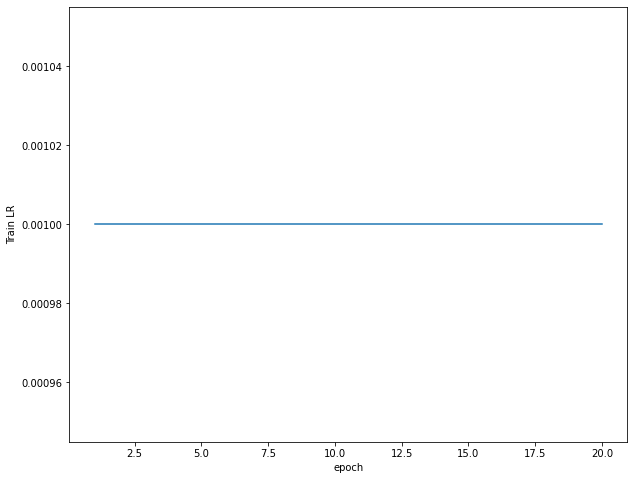

In [23]:
plot_history(epoch ,Acc, Loss, Lr)


### 7. Test


In [24]:
correct = 0 # Define the number of correctly predicted images, initialized to 0
total = 0 # The total number of pictures participating in the test, also initialized to 0
testloader = torch.utils.data.DataLoader(testset, batch_size=32,shuffle=True, num_workers=0)
net.eval()
for data in testloader: # Loop through each batch
    images, labels = data
    images = images.to(device)
    labels = labels.to(device)
    net.eval() # Convert the model to test mode
    if hasattr(torch.cuda, 'empty_cache'):
        torch.cuda.empty_cache()
    outputs = net(images) # Enter the network for testing
    
    # outputs.data is a 4x10 tensor. The value and sequence number of the largest column of each row are formed into a one-dimensional tensor to return, the first is the value tensor, and the second is the sequence number tensor.
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0) # update the number of test images
    correct += (predicted == labels).sum() # update the number of correctly classified images

print('Accuracy of the network on the 10000 test images: %.2f %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 98.79 %


In [25]:
# Define 2 lists that store the number of correct tests in each class, initialized to 0
class_correct = list(0.for i in range(10))
class_total = list(0.for i in range(10))
# testloader = torch.utils.data.DataLoader(testset, batch_size=64,shuffle=True, num_workers=2)
net.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        if hasattr(torch.cuda, 'empty_cache'):
            torch.cuda.empty_cache()
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
    #4 group (batch_size) data, output in the same label, marked as 1, otherwise 0
        c = (predicted == labels).squeeze()
        for i in range(len(images)): # Because each batch has 4 images, a small loop of 4 is needed
            label = labels[i] # Accumulate each class separately
            class_correct[label] += c[i]
            class_total[label] += 1
 
 
for i in range(10):
    print('Accuracy of %5s : %.2f %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of 0 - zero : 99.59 %
Accuracy of 1 - one : 99.65 %
Accuracy of 2 - two : 98.35 %
Accuracy of 3 - three : 99.41 %
Accuracy of 4 - four : 99.29 %
Accuracy of 5 - five : 97.20 %
Accuracy of 6 - six : 99.16 %
Accuracy of 7 - seven : 99.12 %
Accuracy of 8 - eight : 98.97 %
Accuracy of 9 - nine : 97.62 %


Accuracy Rate = 100.0%


<Figure size 1800x288 with 0 Axes>

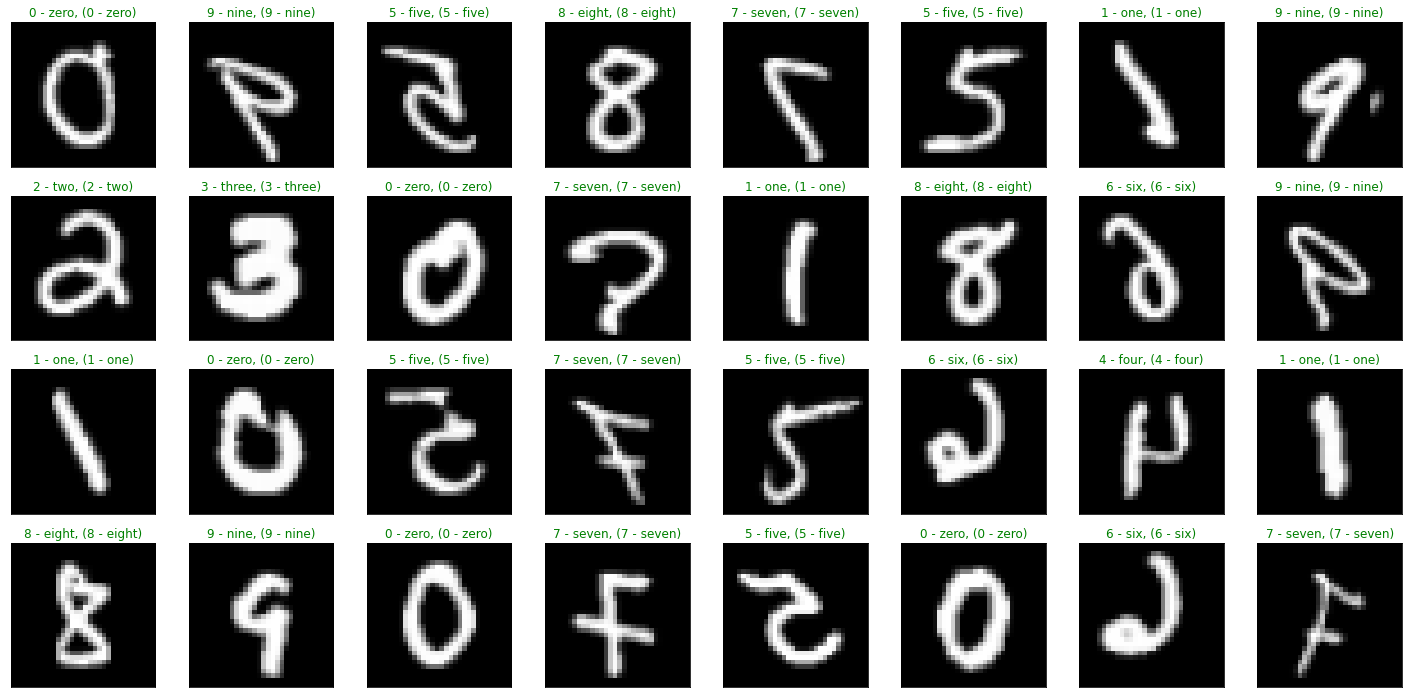

In [26]:
dataiter = iter(testloader)
images, labels = dataiter.next()
images_ = images
#images_ = images_.view(images.shape[0], -1)
images_ = images_.to(device)
labels = labels.to(device)
val_output = net(images_)
_, val_preds = torch.max(val_output, 1)

fig = plt.figure(figsize=(25,4))

correct = torch.sum(val_preds == labels.data).item()

val_preds = val_preds.cpu()
labels = labels.cpu()

print("Accuracy Rate = {}%".format(correct/len(images) * 100))

fig = plt.figure(figsize=(25,25))
for idx in np.arange(32):    
    ax = fig.add_subplot(8, 8, idx+1, xticks=[], yticks=[])
    #fig.tight_layout()
#     plt.imshow(im_convert(images[idx]))
    imshow(images[idx])
    ax.set_title("{}, ({})".format(classes[val_preds[idx].item()], classes[labels[idx].item()]), 
                 color = ("green" if val_preds[idx].item()==labels[idx].item() else "red"))

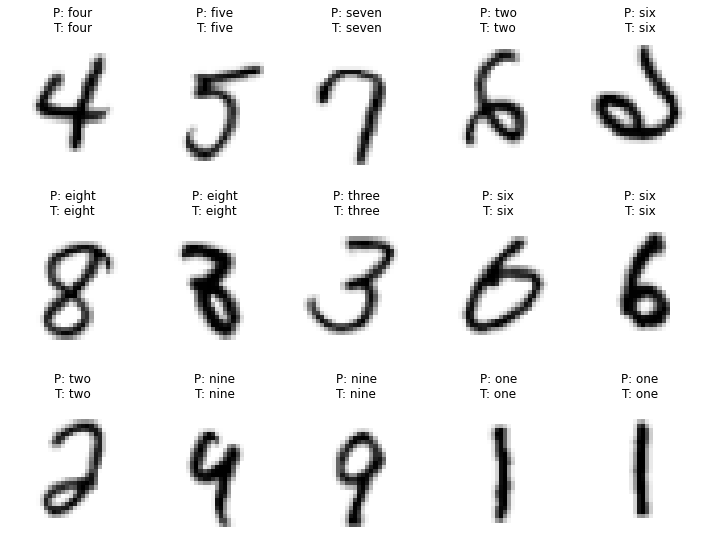

In [27]:
class_dict = {0: 'zero',
              1: 'one',
              2: 'two',
              3: 'three',
              4: 'four',
              5: 'five',
              6: 'six',
              7: 'seven',
              8: 'eight',
              9: 'nine'}


unnormalizer = UnNormalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

show_examples(model=net.to('cuda'), data_loader=testloader, unnormalizer=unnormalizer, class_dict=class_dict)

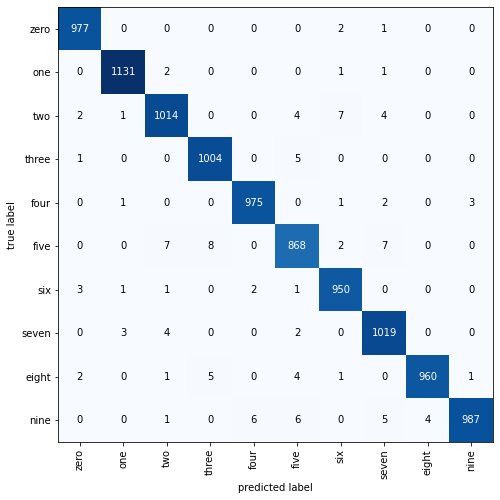

In [28]:
mat = compute_confusion_matrix(model=net, data_loader=testloader, device=torch.device('cpu'))
plot_confusion_matrix(mat, class_names=class_dict.values())
plt.show()


### 8. Save the model


In [29]:
torch.save(net,save_path[:-4]+str(epoch)+'.pth')
# torch.save(net, './model/VGG16-256.pth')

In [30]:
Acc

{'train_acc': [19.200313568115234,
  53.218284606933594,
  92.8887939453125,
  96.9993896484375,
  97.94831085205078,
  98.50634765625,
  98.80230712890625,
  99.07049560546875,
  99.14045715332031,
  99.31314849853516,
  99.43696594238281,
  99.52637481689453,
  99.57855987548828,
  99.67850494384766,
  99.70182800292969,
  99.7279281616211,
  99.79622650146484,
  99.83342742919922,
  99.84508514404297,
  99.87840270996094],
 'test_acc': [29.806171417236328,
  84.88924407958984,
  95.88607788085938,
  97.03323364257812,
  98.04193115234375,
  97.37935638427734,
  98.4078369140625,
  98.47705841064453,
  98.59573364257812,
  98.87262725830078,
  98.65506744384766,
  98.78362274169922,
  98.5462875366211,
  98.80340576171875,
  98.76384735107422,
  98.88251495361328,
  98.86273956298828,
  99.01107788085938,
  98.78362274169922,
  98.89241027832031]}

In [31]:
Loss

{'train_loss': [2.2250874042510986,
  1.2631279230117798,
  0.2555975615978241,
  0.10855711251497269,
  0.07221461087465286,
  0.05396101251244545,
  0.04224070906639099,
  0.03406050056219101,
  0.027971722185611725,
  0.023272691294550896,
  0.01895887590944767,
  0.016536859795451164,
  0.014540033414959908,
  0.011524532921612263,
  0.011235751211643219,
  0.009710756130516529,
  0.008321848697960377,
  0.006889214273542166,
  0.005895174108445644,
  0.004829200450330973],
 'test_loss': [1.893747091293335,
  0.4816565215587616,
  0.14041367173194885,
  0.10803937911987305,
  0.06405771523714066,
  0.08330684155225754,
  0.05401846766471863,
  0.04687724635004997,
  0.046650905162096024,
  0.038181889802217484,
  0.04427105560898781,
  0.04732862859964371,
  0.05330358073115349,
  0.04396003857254982,
  0.04531869664788246,
  0.043421901762485504,
  0.04560495913028717,
  0.0395086444914341,
  0.04404180496931076,
  0.04107850417494774]}